In [1]:
print("all ok")

all ok


In [2]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\tessd\ARRG2026\automated-research-report-generation


In [3]:
from research_and_analyst.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2026-01-29T22:34:19.778704Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2026-01-29T22:34:19.779706Z", "level": "warning", "event": "GOOGLE_API_KEY is missing from environment"}
{"timestamp": "2026-01-29T22:34:19.780706Z", "level": "warning", "event": "GROQ_API_KEY is missing from environment"}
{"config_keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-01-29T22:34:19.786084Z", "level": "info", "event": "YAML config loaded"}


In [5]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-5.2", "timestamp": "2026-01-29T22:34:26.383296Z", "level": "info", "event": "Loading LLM"}


In [6]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hi—what can I help you with today?'

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [9]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [10]:
Analyst(
    name="Tess Aquino",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='Tess Aquino', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [11]:
analyst = Analyst(
    name="Tess Aquino",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [12]:
analyst.name

'Tess Aquino'

In [13]:
analyst.role

'genai eng'

In [14]:
analyst.affiliation

'AI Research LAB'

In [15]:
print(analyst.persona)

Name: Tess Aquino
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [16]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [17]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [18]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [19]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [20]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [21]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [22]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [23]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Maya Chen, MPH', role='Evidence-based Public Health & Prevention Analyst', affiliation='Independent public health researcher (former local health department epidemiology lead)', description='Focuses on what is supported by high-quality evidence (systematic reviews, RCTs, well-designed cohort studies) for prevention and population health: vaccines, screening, tobacco/alcohol harm reduction, diet and physical activity, and environmental risk factors. Prioritizes real-world effect sizes, absolute risk, and harms/benefits (including equity impacts). Pushes back on hype, wellness misinformation, and overgeneralized claims by asking: What’s the evidence quality, baseline risk, and practical impact for typical people?'),
  Analyst(name='Dr. Samuel Ortiz, MD', role='Clinical Medicine & Patient Decision Analyst', affiliation='Hospital-based internist and clinical guideline contributor', description='Interprets health claims through bedside realities: differential

In [24]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [25]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [26]:
from IPython.display import Image, display

## First Workflow

In [27]:
builder = StateGraph(GenerateAnalystsState)

In [28]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [29]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [30]:
memory = MemorySaver()

In [31]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

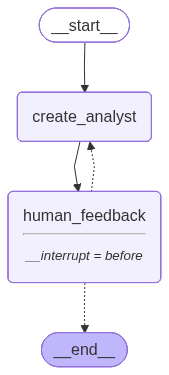

In [32]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [33]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [34]:
max_analysts = 4

In [35]:
thread =  {"configurable":{"thread_id":1}}

In [36]:
for event in graph.stream({"topic":topic,
            "max_analysts":max_analysts},
            thread,
            stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Maya Chen
Affiliation: Enterprise AI Platform Engineering
Role: Platform Architect (Agent Orchestration & Reliability)
Description: Evaluates LangGraph for building stateful, production-grade agent systems. Focuses on deterministic control flow, graph-based orchestration, observability, reproducibility, and failure handling (timeouts, retries, checkpoints, human-in-the-loop). Motive: reduce incident rates and make agent behavior auditable and operable at scale.
--------------------------------------------------
Name: Ravi Patel
Affiliation: Applied LLM Product Team
Role: AI Product Lead (Time-to-Market & Developer Experience)
Description: Assesses whether LangGraph accelerates delivery of agent features versus ad-hoc frameworks. Focuses on ergonomics, composability, iteration speed, testability, and how well LangGraph supports common product patterns (tool use, routing, multi-step workflows, approvals). Motive: ship reliable agent experiences quickly with maintainable code.
-----

In [37]:
state = graph.get_state(thread)

In [38]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Maya Chen', role='Platform Architect (Agent Orchestration & Reliability)', affiliation='Enterprise AI Platform Engineering', description='Evaluates LangGraph for building stateful, production-grade agent systems. Focuses on deterministic control flow, graph-based orchestration, observability, reproducibility, and failure handling (timeouts, retries, checkpoints, human-in-the-loop). Motive: reduce incident rates and make agent behavior auditable and operable at scale.'), Analyst(name='Ravi Patel', role='AI Product Lead (Time-to-Market & Developer Experience)', affiliation='Applied LLM Product Team', description='Assesses whether LangGraph accelerates delivery of agent features versus ad-hoc frameworks. Focuses on ergonomics, composability, iteration speed, testability, and how well LangGraph supports common product patterns (tool use, routing, multi-st

In [39]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Maya Chen', role='Platform Architect (Agent Orchestration & Reliability)', affiliation='Enterprise AI Platform Engineering', description='Evaluates LangGraph for building stateful, production-grade agent systems. Focuses on deterministic control flow, graph-based orchestration, observability, reproducibility, and failure handling (timeouts, retries, checkpoints, human-in-the-loop). Motive: reduce incident rates and make agent behavior auditable and operable at scale.'),
  Analyst(name='Ravi Patel', role='AI Product Lead (Time-to-Market & Developer Experience)', affiliation='Applied LLM Product Team', description='Assesses whether LangGraph accelerates delivery of agent features versus ad-hoc frameworks. Focuses on ergonomics, composability, iteration speed, testability, and how well LangGraph supports common product patterns (tool use, routing, multi-step workflows, app

In [40]:
state.next

('human_feedback',)

In [41]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0fd62e-e122-65a0-bfff-1641f42d6e24': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2026-01-29T22:36:19.127439+00:00\xa2id\xd9$1f0fd62e-e122-65a0-bfff-1641f42d6e24\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.20670038117123435\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0fd62e-e127-6b7e-8000-a1de4f468794': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2026-01-29T22:36:19.129638+00:00\xa2id\xd9$1f0fd62e-e127-6b7e-8000-a1de4f468794\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.5666141236378032\xa5topic\xd9300000000000000000000000000000002.0.5666141236378032\xacmax_analysts\xd9300000000000000000000000000000002.0.5666141236378032\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.5666141236378032\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\x

In [ ]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [42]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fd62f-41b2-68f0-8001-93b72d046ae0'}}

In [43]:
graph.update_state(thread,
                {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fd630-2f00-65d0-8002-149983ca7883'}}

In [44]:
for event in graph.stream({"topic":topic,
            "max_analysts":max_analysts},
            thread,
            stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Maya Chen
Affiliation: Enterprise AI Platform Engineering
Role: Platform Architect (Agent Orchestration & Reliability)
Description: Evaluates LangGraph for building stateful, production-grade agent systems. Focuses on deterministic control flow, graph-based orchestration, observability, reproducibility, and failure handling (timeouts, retries, checkpoints, human-in-the-loop). Motive: reduce incident rates and make agent behavior auditable and operable at scale.
--------------------------------------------------
Name: Ravi Patel
Affiliation: Applied LLM Product Team
Role: AI Product Lead (Time-to-Market & Developer Experience)
Description: Assesses whether LangGraph accelerates delivery of agent features versus ad-hoc frameworks. Focuses on ergonomics, composability, iteration speed, testability, and how well LangGraph supports common product patterns (tool use, routing, multi-step workflows, approvals). Motive: ship reliable agent experiences quickly with maintainable code.
-----

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Maya Iyer
Affiliation: Global Financial Services (CIO Platform Engineering)
Role: Enterprise AI Platform Architect
Description: Evaluates LangGraph as a production-grade agent orchestration layer for large enterprises. Focuses on benefits like controllable state machines/graphs, deterministic routing, human-in-the-loop checkpoints, auditability, and policy enforcement. Prioritizes integration with identity/access controls, observability, CI/CD, and governance requirements (e.g., traceability, approvals, and change management) to safely scale agentic workflows across business units.
--------------------------------------------------
Name: Jordan Kim
Affiliation: Seed-to-Series A B2B SaaS Startup
Role: Startup CTO / Product-Led Agent Builder
Description: Assesses LangGraph from a startup perspective where speed, iteration, and cost efficiency matter. Focuses on how LangGraph enables rapid prototyping of multi-step agents while still providing a clear path to production (state persi

In [45]:
state = graph.get_state(thread)

In [46]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Maya Iyer', role='Enterprise AI Platform Architect', affiliation='Global Financial Services (CIO Platform Engineering)', description='Evaluates LangGraph as a production-grade agent orchestration layer for large enterprises. Focuses on benefits like controllable state machines/graphs, deterministic routing, human-in-the-loop checkpoints, auditability, and policy enforcement. Prioritizes integration with identity/access controls, observability, CI/CD, and governance requirements (e.g., traceability, approvals, and change management) to safely scale agentic workflows across business units.'), Analyst(name='Jordan Kim', role='Startup CTO / Product-Led Agent Builder', affiliation='Seed-to-Series A B2B SaaS Startup', description='Assesses 

In [47]:
state.next

('human_feedback',)

In [48]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Maya Iyer', role='Enterprise AI Platform Architect', affiliation='Global Financial Services (CIO Platform Engineering)', description='Evaluates LangGraph as a production-grade agent orchestration layer for large enterprises. Focuses on benefits like controllable state machines/graphs, deterministic routing, human-in-the-loop checkpoints, auditability, and policy enforcement. Prioritizes integration with identity/access controls, observability, CI/CD, and governance requirements (e.g., traceability, approvals, and change management) to safely scale agentic workflows across business units.'),
  Analyst(name='Jordan Kim', role='Startup CTO / Product-Led Agent Builder', affiliation='Seed-to-Series A B2B SaaS Startup', description='Assesses LangGraph from a

In [ ]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [49]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [50]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [51]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fd631-8c26-66d8-8006-cf4de150d98b'}}

In [52]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [53]:
analysts = final_state.values.get('analysts')

In [54]:
analysts

[Analyst(name='Maya Iyer', role='Enterprise AI Platform Architect', affiliation='Global Financial Services (CIO Platform Engineering)', description='Evaluates LangGraph as a production-grade agent orchestration layer for large enterprises. Focuses on benefits like controllable state machines/graphs, deterministic routing, human-in-the-loop checkpoints, auditability, and policy enforcement. Prioritizes integration with identity/access controls, observability, CI/CD, and governance requirements (e.g., traceability, approvals, and change management) to safely scale agentic workflows across business units.'),
 Analyst(name='Jordan Kim', role='Startup CTO / Product-Led Agent Builder', affiliation='Seed-to-Series A B2B SaaS Startup', description='Assesses LangGraph from a startup perspective where speed, iteration, and cost efficiency matter. Focuses on how LangGraph enables rapid prototyping of multi-step agents while still providing a clear path to production (state persistence, retries, m

In [55]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Maya Iyer
Affiliation: Global Financial Services (CIO Platform Engineering)
Role: Enterprise AI Platform Architect
Description: Evaluates LangGraph as a production-grade agent orchestration layer for large enterprises. Focuses on benefits like controllable state machines/graphs, deterministic routing, human-in-the-loop checkpoints, auditability, and policy enforcement. Prioritizes integration with identity/access controls, observability, CI/CD, and governance requirements (e.g., traceability, approvals, and change management) to safely scale agentic workflows across business units.
--------------------------------------------------
Name: Jordan Kim
Affiliation: Seed-to-Series A B2B SaaS Startup
Role: Startup CTO / Product-Led Agent Builder
Description: Assesses LangGraph from a startup perspective where speed, iteration, and cost efficiency matter. Focuses on how LangGraph enables rapid prototyping of multi-step agents while still providing a clear path to production (state persi

In [56]:
"The benefits of adopting LangGraph as an agent framework"

'The benefits of adopting LangGraph as an agent framework'

In [57]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


Either you can use Google Serper API or use duckduckgo

In [58]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs[0].page_content[:500])

Cloud computing is defined by the ISO as "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on demand". It is commonly referred to as "the cloud".


== Characteristics ==
In 2011, the National Institute of Standards and Technology (NIST) identified five "essential characteristics" for cloud systems. Below are the exact definitions according to NIST:

On-demand self-service: "A consume


In [59]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs)

[Document(metadata={'title': 'Serverless computing', 'summary': 'Serverless computing is "a cloud service category where the customer can use different cloud capability types without the customer having to provision, deploy and manage either hardware or software resources, other than providing customer application code or providing customer data. Serverless computing represents a form of virtualized computing", according to ISO/IEC 22123-2. Serverless computing is a broad ecosystem that includes the cloud provider, function as a service (FaaS), managed services, tools, frameworks, engineers, stakeholders, and other interconnected elements.\n\n', 'source': 'https://en.wikipedia.org/wiki/Serverless_computing'}, page_content='Serverless computing is "a cloud service category where the customer can use different cloud capability types without the customer having to provision, deploy and manage either hardware or software resources, other than providing customer application code or providin

In [60]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="AWS").load()
print(docs[0].page_content[:500])

c:\Users\tessd\ARRG2026\automated-research-report-generation\.venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\tessd\ARRG2026\automated-research-report-generation\.venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Amazon Web Services, Inc. (AWS) is a subsidiary of Amazon that provides on-demand cloud computing platforms and APIs to individuals, companies, and governments, on a metered, pay-as-you-go basis.
Clients often use this in combination with autoscaling (a process that allows a client to use more computing in times of high application usage, and then scale down to reduce costs when there is less traffic). These cloud computing web services provide various services related to networking, compute, st


In [61]:
from langchain_community.utilities import WikipediaAPIWrapper

In [62]:
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

## Second Workflow

In [63]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [64]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [65]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\tessd\AppData\Local\Temp\ipykernel_25652\1029971610.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [66]:
tavily_search.invoke("langgraph")

[{'title': 'LangGraph overview - Docs by LangChain',
  'url': 'https://docs.langchain.com/oss/python/langgraph/overview',
  'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.LangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.We will commonly use LangChain components throughout the documentation to integrate models and tools, but you don’t need to use LangChain to use LangGraph. If you are just getting started with agents or want a higher-level abstraction, we recommend you use LangChain’s agents that provide pre-built architectures for common LLM and tool-calling [...] LangGraph provides low-level supporting infrastructure for _any_ long-r

In [67]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 

In [68]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [69]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [70]:
print(analyst.persona)

Name: Ravi Patel
Role: Enterprise Automation & Workflow Modernization Lead
Affiliation: Fortune 500 Operations Transformation Office
Description: Focuses on the latest enterprise applications of agent frameworks: customer support copilots, IT service management, procurement ops, finance close, and knowledge workflows. Evaluates LangGraph’s ability to orchestrate multi-agent collaboration, integrate with RPA/enterprise APIs, and support long-running processes (handoffs, escalations, approvals). Measures benefits in cycle-time reduction, process compliance, and maintainability compared with monolithic automation scripts or ad-hoc agent implementations.



In [71]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Ravi Patel\nRole: Enterprise Automation & Workflow Modernization Lead\nAffiliation: Fortune 500 Operations Transformation Office\nDescription: Focuses on the latest enterprise applications of agent frameworks: customer support copilots, IT service management, procurement ops, finance close, and knowledge workflows. Evaluates LangGraph’s ability to orchestrate multi-agent collaboration, integrate with RPA/enterprise APIs, and support long-running processes (handoffs, escalations, approvals). Measures benefits in cycle-time reduction, process compliance, and maintainability compared with mono

In [72]:
'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.'

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you

In [73]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [74]:
analyst

Analyst(name='Ravi Patel', role='Enterprise Automation & Workflow Modernization Lead', affiliation='Fortune 500 Operations Transformation Office', description='Focuses on the latest enterprise applications of agent frameworks: customer support copilots, IT service management, procurement ops, finance close, and knowledge workflows. Evaluates LangGraph’s ability to orchestrate multi-agent collaboration, integrate with RPA/enterprise APIs, and support long-running processes (handoffs, escalations, approvals). Measures benefits in cycle-time reduction, process compliance, and maintainability compared with monolithic automation scripts or ad-hoc agent implementations.')

In [75]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [76]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [77]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Ravi Patel', role='Enterprise Automation & Workflow Modernization Lead', affiliation='Fortune 500 Operations Transformation Office', description='Focuses on the latest enterprise applications of agent frameworks: customer support copilots, IT service management, procurement ops, finance close, and knowledge workflows. Evaluates LangGraph’s ability to orchestrate multi-agent collaboration, integrate with RPA/enterprise APIs, and support long-running processes (handoffs, escalations, approvals). Measures benefits in cycle-time reduction, process compliance, and maintainability compared with monolithic automation scripts or ad-hoc agent implementations.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [78]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [79]:
result

{'messages': [AIMessage(content='I’m Maya, an enterprise automation analyst. To “do the proper search” in Ravi Patel’s area of expertise, I need to pin down exactly what you want to learn/build so I can target the right artifacts (LangGraph patterns, enterprise integrations, governance, metrics, etc.).\n\n1) Which process are you focusing on?\n- Customer support copilot\n- ITSM (ServiceNow/Jira)\n- Procurement ops (Coupa/Ariba)\n- Finance close (SAP/Oracle)\n- Knowledge workflows (SharePoint/Confluence)\n\n2) What’s your main evaluation goal?\n- Cycle-time reduction\n- Process compliance/auditability\n- Maintainability vs monolithic scripts\n- Long-running orchestration (handoffs/escalations/approvals)\n- Integration depth (RPA, APIs, event queues)\n\n3) What environment constraints should I assume?\n- Key systems (e.g., ServiceNow, SAP, Coupa, Okta, email, Teams/Slack)\n- RPA tool (UiPath/Automation Anywhere/Power Automate)\n- Data/security constraints (PII, SOC2, HIPAA, on-prem)\n\n4

In [80]:
print(result["messages"][0].content)

I’m Maya, an enterprise automation analyst. To “do the proper search” in Ravi Patel’s area of expertise, I need to pin down exactly what you want to learn/build so I can target the right artifacts (LangGraph patterns, enterprise integrations, governance, metrics, etc.).

1) Which process are you focusing on?
- Customer support copilot
- ITSM (ServiceNow/Jira)
- Procurement ops (Coupa/Ariba)
- Finance close (SAP/Oracle)
- Knowledge workflows (SharePoint/Confluence)

2) What’s your main evaluation goal?
- Cycle-time reduction
- Process compliance/auditability
- Maintainability vs monolithic scripts
- Long-running orchestration (handoffs/escalations/approvals)
- Integration depth (RPA, APIs, event queues)

3) What environment constraints should I assume?
- Key systems (e.g., ServiceNow, SAP, Coupa, Okta, email, Teams/Slack)
- RPA tool (UiPath/Automation Anywhere/Power Automate)
- Data/security constraints (PII, SOC2, HIPAA, on-prem)

4) What output do you want from me?
- A curated reading

In [81]:
from langchain_core.messages import get_buffer_string

In [82]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [83]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [84]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [85]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [86]:
print(result["context"][0])

<Document href="https://www.blocshop.io/blog/langchain-and-langgraph-and-why-these-frameworks-are-becoming-common-in-ai-projects"/>
### LangGraph in practice

Teams use LangGraph when reliability and control matter. A multi-agent workflow, a document-processing system with several approval points, or an automation pipeline that needs to revisit earlier steps will always outgrow a linear approach.

LangGraph keeps the process consistent: it manages state, handles transitions, supports retries, records what happened, and prevents the workflow from drifting into unintended behaviour.

The trade-off is that it requires more thoughtful design upfront, but once the system matures, the benefits are clear — predictable execution, easier debugging, and workflows that match the complexity of the real task.

Why teams are choosing these frameworks [...] Nodes represent actions or agents, edges show transitions, and the framework keeps track of what the system already knows as it moves through the

In [87]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [88]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [89]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='LangGraph framework what is it and why businesses adopt it strategic implications innovation digital transformation use cases'


In [90]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [91]:
search_docs

[]

In [92]:
result

{'context': ['<Document source="https://en.wikipedia.org/wiki/Big_data" page=""/>\nBig data primarily refers to data sets that are too large or complex to be dealt with by traditional data-processing software. Data with many entries (rows) offer greater statistical power, while data with higher complexity (more attributes or columns) may lead to a higher false discovery rate.\nBig data analysis challenges include capturing data, data storage, data analysis, search, sharing, transfer, visualization, querying, updating, information privacy, and data source. Big data was originally associated with three key concepts: volume, variety, and velocity. The analysis of big data that have only volume velocity and variety can pose challenges in sampling. A fourth concept, veracity, that refers to the level of reliability of data was thus added. Without sufficient investment in expertise for big data veracity, the volume and variety of data can produce costs and risks that exceed an organization\'

In [93]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [94]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [95]:
def route_messages(state: InterviewState, 
                name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [96]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [97]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [98]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [99]:
interview_builder = StateGraph(InterviewState)

In [100]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [101]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                        route_messages,
                        ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [102]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


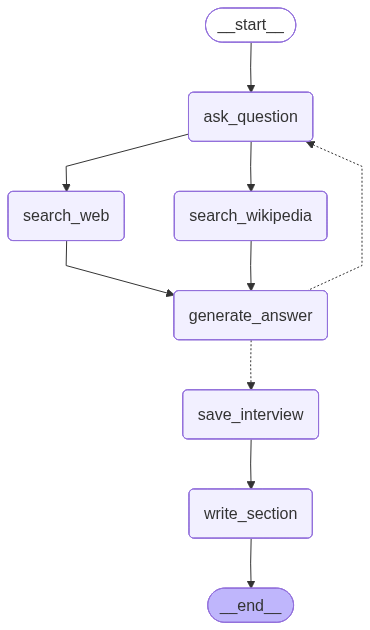

In [103]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [104]:
analyst

Analyst(name='Ravi Patel', role='Enterprise Automation & Workflow Modernization Lead', affiliation='Fortune 500 Operations Transformation Office', description='Focuses on the latest enterprise applications of agent frameworks: customer support copilots, IT service management, procurement ops, finance close, and knowledge workflows. Evaluates LangGraph’s ability to orchestrate multi-agent collaboration, integrate with RPA/enterprise APIs, and support long-running processes (handoffs, escalations, approvals). Measures benefits in cycle-time reduction, process compliance, and maintainability compared with monolithic automation scripts or ad-hoc agent implementations.')

In [105]:
analyst.persona

'Name: Ravi Patel\nRole: Enterprise Automation & Workflow Modernization Lead\nAffiliation: Fortune 500 Operations Transformation Office\nDescription: Focuses on the latest enterprise applications of agent frameworks: customer support copilots, IT service management, procurement ops, finance close, and knowledge workflows. Evaluates LangGraph’s ability to orchestrate multi-agent collaboration, integrate with RPA/enterprise APIs, and support long-running processes (handoffs, escalations, approvals). Measures benefits in cycle-time reduction, process compliance, and maintainability compared with monolithic automation scripts or ad-hoc agent implementations.\n'

In [106]:
thread = {"configurable": {"thread_id": "1"}}

In [107]:
from IPython.display import Markdown

In [108]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [109]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='LangChain vs LangGraph article enterprise use cases multi-agent orchestration long-running workflows approvals audit compliance SAP ServiceNow ITSM RPA BPM comparison'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='LangChain article outline enterprise use cases LangChain vs LangGraph differences orchestration long-running workflows human-in-the-loop approvals'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [110]:
Markdown(interview['sections'][0])

## LangGraph in the Enterprise: Orchestrating Stateful, Multi-Agent Workflows for Support, ITSM, and Ops

### Summary
Enterprise AI agents are moving from “single prompt → single answer” demos to workflow-native systems that must handle long-running processes, branching decisions, retries, and human approvals across customer support, IT service management, procurement operations, and finance/knowledge workflows. The key architectural shift is from linear, stateless pipelines to stateful orchestration that can coordinate multiple specialized agents and tools while maintaining auditability and operational control.

Across the sources, LangGraph is positioned as the mechanism that makes this shift practical in production. Unlike prompt-chaining approaches optimized for predictable sequences, LangGraph models work as a graph with explicit state transitions, enabling loops, conditional routing, parallelism, and retries—features that matter when real enterprise cases require escalation paths, verification cycles, or multi-step handoffs rather than a single “best effort” response [2][4]. Multiple sources emphasize that this structure is particularly well-suited to complex customer support agents where dynamic decision-making, statefulness, and human intervention are first-class requirements, not bolt-ons [9][6].

A notable (and enterprise-relevant) insight is the emphasis on inspectability and durability: LangGraph supports “durable execution” so workflows can persist through failures and resume, which maps directly to long-running processes like ticket lifecycles, approvals, and finance-close checklists [8]. Debuggability is treated as a core capability as well—state inspection and verbose logs at each node make it easier to diagnose bad transitions, tool failures, or model errors, improving maintainability compared with ad-hoc agent implementations [2][8]. Human-in-the-loop controls are repeatedly highlighted: teams can inspect and even modify agent state mid-flight, supporting compliance-minded deployments where oversight and intervention are mandatory [8][3].

Finally, the sources illustrate how LangGraph fits into broader enterprise stacks rather than replacing them. It’s framed as complementary to LangChain components (connectors, RAG building blocks), with LangGraph providing the “workflow brain” once systems outgrow linear orchestration [4][2]. Practical examples show multi-agent routing plus RAG retrieval/reranking, and runtime controls that allow changing agent behavior without redeploying code—an operational lever that can reduce cycle time for iteration and governance updates [5].

### Sources
[1] https://www.scalablepath.com/machine-learning/langgraph/  
[2] https://medium.com/@randomtrees/langchain-vs-langgraph-orchestrating-the-future-of-generative-ai-pipelines-b1e24967fda7/  
[3] https://www.ibm.com/think/topics/langchain/  
[4] https://milvus.io/blog/langchain-vs-langgraph.md  
[5] https://launchdarkly.com/docs/tutorials/agents-langgraph  
[6] https://www.truefoundry.com/blog/langchain-vs-langgraph/  
[8] https://docs.langchain.com/oss/python/langgraph/overview  
[9] https://www.eesel.ai/blog/langchain-vs-langgraph/

## Third Workflow

In [116]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report
    

In [126]:
from langgraph.types import Send

In [127]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]


In [ ]:
# def write_report(state:ResearchGraphState):
#     """_summary_

#     Args:
#         state (ResearchGraphState): _description_
#     """
#     pass

In [128]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [129]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [130]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [131]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [ ]:
# def write_report(state:ResearchGraphState):
#     # Full set of sections
#     sections = state["sections"]
#     topic = state["topic"]
    
#     # Concat all sections together
#     formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
#     # Summarize the sections into a final report
#     instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
#     intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
#     return {"introduction": intro.content}

    

In [132]:
def write_conclusion(stae:ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}
    

In [133]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [134]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)


In [135]:
memory = MemorySaver()

In [136]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

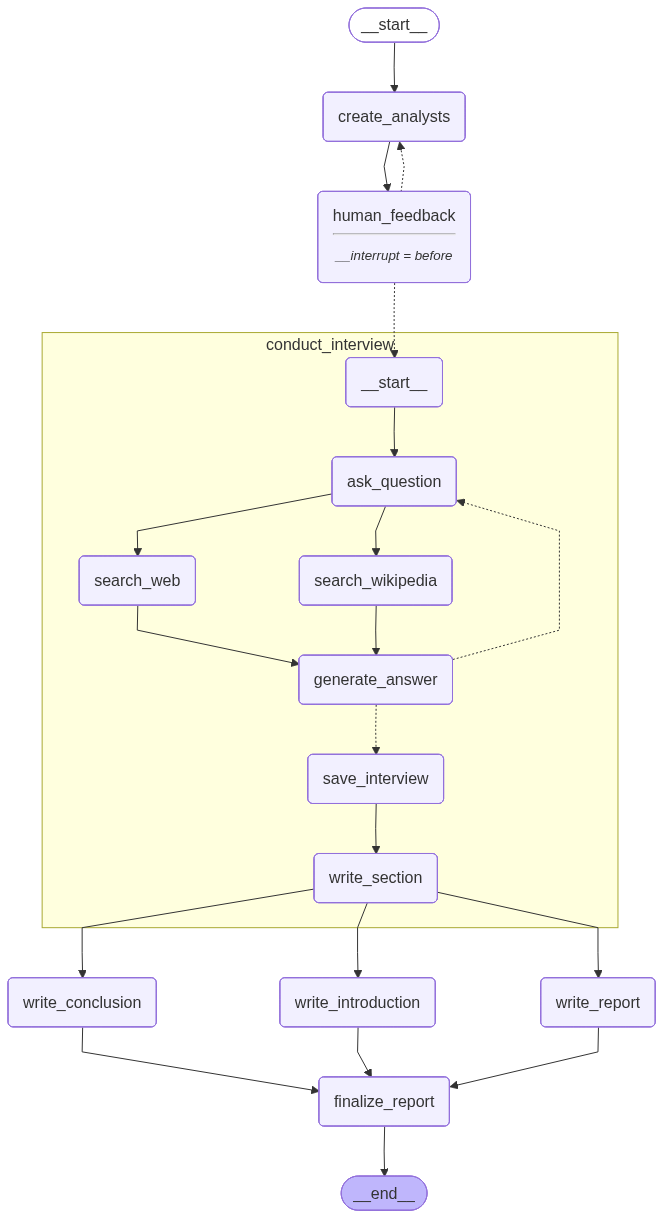

In [137]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Jinja Pormpting

if else

beautiful UI

## mega assignment

1. connnect multiple data source
2. how to divide this artitecture on a grnular level

In [ ]:
print("hi")